In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (12,7)

## Step 0
### Data Acquisition

In [2]:
tickers_market = ['SPY']
tickers_energy = ['XLE', 'XOP']
tickers_gold = ['GDX', 'GLD']
tickers_tech = ['IYW', 'XLK']

start = '2017-01-01'
end = '2022-01-01'

data_market = yf.download(tickers_market, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_energy = yf.download(tickers_energy, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_gold = yf.download(tickers_gold, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_tech = yf.download(tickers_tech, start=start, end=end, progress=False, auto_adjust=True)["Close"]  # type: ignore

prices = pd.concat([data_market, data_energy, data_gold, data_tech], axis=1)
rets = pd.DataFrame(np.log(prices / prices.shift(1))).dropna()
# rets

## Step 2

### Describe the complete pair strategy adopted, composed of: (a) a baseline strategy based on the co-integrated spread of the chosen ETF pair trade, and (b) an added volatility regime-switching indicator, that activates the baseline strategy only when within the low-volatility regime.

The pair trading strategy illustrated in this report consists identifying ETFs belonging to the same economic sector, covering similar assets and replicating similar indices.
These ETFs should theoretically respond in a synchronised way to the vagaries of the markets.

In the jargon of Econometrics, this observation can be associated with the concept of two time series being *cointegrated*.
Cointegration is a more stringent condition than correlation: it prescribes the series do not just move with the same trend, but also keep their distance (difference of values at the same position in the time series) within a certain band.
Given this definition, it seems then logical to associate cointegration with the notion of mean-reversion of a time series, and hence, to its stationarity.
In literature, there exist six statistical tests that can be performed on a pair of time series, to verify whether they are co-integrated.

In this report, we have resorted to the Engle-Granger test in previous section 1.b, to check for cointegration of three pairs of ETFs, belonging to the energy, gold and technology sectors.
This test regresses one of the series, using the other one as exogenous variable.
The residuals of the linear regression are then checked for stationarity, which is attained in the absence of unit roots.
The stationarity test we used in the previous section is the augmented Dickey-Fuller test, which rejects the null hypothesis of non-stationarity if the $p$-value of the associated Dickey-Fuller statistic is $< 0.05$.
Success of the ADF test on the residuals of the regression (spread) also allows to define the two original time series as cointegrated in the Engle-Granger sense. 

A pair trading strategy based on two cointegrated price series would exploit the expected stationarity, hence mean reversion of their spread, in case their spread on the markets strays outside of the expected band of mean reversion, breaching either the negative or the positive threshold.
This is seen as an anomaly for cointegrated time series, that should quickly retreat back within the accepted band of mean reversion for the series spread.

However, like correlation, cointegration between assets might radically break down and reconfigure in times of economic crisis.
In section 1c, we have identified two volatility regimes within the financial markets, based on the evolution of SPY for the period 2017-22.

Here, we upgrade the pair trading strategy already sketched in section 1b, with an additional indicator of high-volatility regime in the markets.
When we enter a period of high volatility in the markets, that could potentially turn into a fully fledged crisis where our pair cointegration might break down, the indicator activates.
The pair strategy is then directed to relinquish taking any position in the two ETFs composing the pair, until the high-volatility regime subsumes.

This expedient helps the strategy to avoid investing in periods when the cointegration relation, which lies at the basis of pair trading, might not hold, and thus the original vanilla pair strategy would be no better than random betting on the markets, and would result in realised looses.

#### Description of the volatility regime-switching indicator

Here we employ code and results from section 1.c to construct the volatility-regime-switching indicator.

From that section, we know that the Markov switching regression model is built on python with the `MarkovAutoregression` class in statsmodels.
The class is fed initial state and boundary limits to its inner optimisation algorithm from observation of the time series of SPY during the timeframe of reference, as already described in section 1.c.

The class can output the smoothed probabilities for each regime to happen during the timeframe.
*Smoothed*, as opposed to *filtered* probabilities are computed for each time point $t$ using a larger number of neighbouring points, hence giving a more regular appearance than filtered probabilities, which are more locally restricted.

Our high volatility regime-switching indicator $I_{h \sigma}$ is derived from the smoothed probabilities of high volatility, $p_{h \sigma,\,\text{smooth}}$, by switching on the signal when smoothed probabilities of high vol are $p_{h \sigma,\,\text{smooth}} \geq 0.9$.

$$
I_{h \sigma} = \begin{cases}
    1 & p_{h \sigma,\,\text{smooth}} \geq 0.9\\
	0 & p_{h \sigma,\,\text{smooth}} < 0.9
\end{cases}
$$

We plot $I_{h \sigma}$ in the graph below.

In [3]:
# b add volatility-switch indicator to the strategy
# from step 1c
mod_spy = sm.tsa.MarkovAutoregression(rets["SPY"], k_regimes=2, order=1, trend='c', switching_ar=True, switching_variance=True)

# halflife
tau_days = np.array([10.5, 21]) # SPY returns half-revert in 10 days when low vol, in 21 when high vol
business_year_in_days = 252
tau = tau_days / business_year_in_days
# UO's mean reversion adapted to AR(1)'s beta
log2 = np.log(2)
kappa = log2 / tau
beta = np.exp(-kappa / business_year_in_days)

mu = [0.0005, -0.0010]
alpha = mu * (1 - beta)

sigma = [0.008, 0.02]

# rough estimation of logit^-1(transition probabilities)
P = np.array([0.9, 0.5])
logit = np.exp(P)/(1 + np.exp(P))

start = mod_spy.start_params.copy()
start[:2] = logit       # logit(P)       # mu guesses: calm 20 bp, stress 200 bp
start[2:4] = alpha  # mu          # beta guesses: kappa approx 2.3 /yr vs 1.0 /yr
start[4:6] = np.square(sigma)           # sigma guesses
# logit(P00) ~ 2.5  -> P00 approx 0.92 ; logit(P11) ~ 0   -> P11 approx 0.5
start[6:8] = beta  # beta

# bounds:   alpha ≥ 0,   0.70 <= beta <= 0.95,   sigma ≥ 1e‑3,   transition logits free
b = [(0.25, 0.931), (0.25, 0.931), #(0.5, 0.731), (0.5, 0.731), # P         # mu
	(-0.001, 0.1), (-0.001, 0.1), #(-0.01, 0.01), (-0.01, 0.01), # mu   # beta
	(1e-3, 1e6), (1e-3, 1e6),    # sigma
	(0.50, 1.3), (0.50, 1.3)]  #beta  # logits of P

np.random.seed(1234)
spy_markov_results = mod_spy.fit(start_params=start, bounds=b, method="bfgs", maxiter=500, search_reps=20)

In [4]:
# high vol regime indicator to be used inside pair strategy
switch_high_vol = spy_markov_results.smoothed_marginal_probabilities[0] > 0.9
# switch_high_vol 

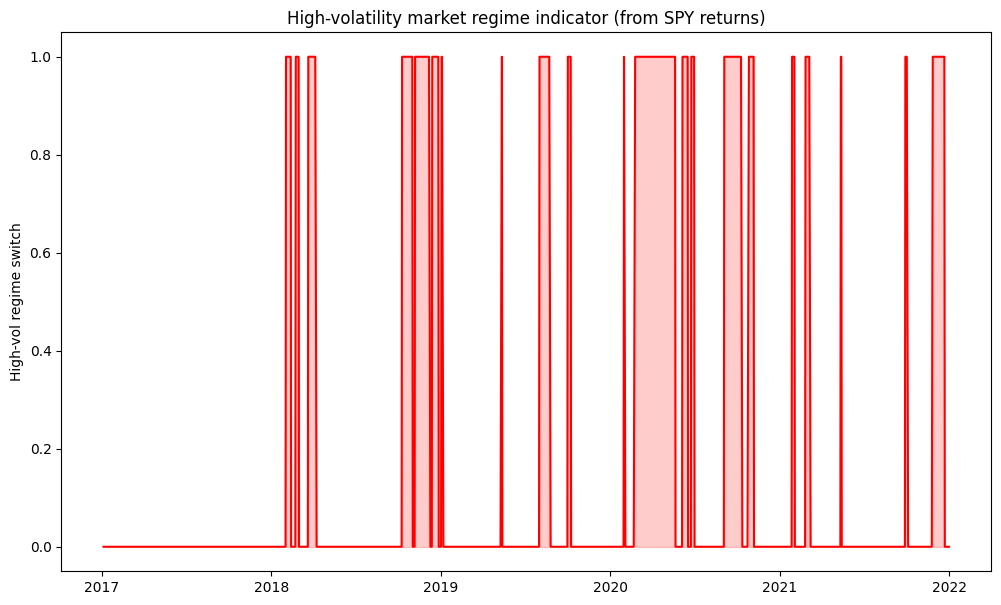

In [5]:
#fig, axes = plt.subplots(2)

# ax = axes[0]
# ax.plot(spy_markov_results.smoothed_marginal_probabilities[1],'g')
# ax.set(title="Probability of a low-volatility regime for SPY returns")

plt.plot(switch_high_vol,'r')
plt.fill_between(switch_high_vol.index, 0, 1, where=switch_high_vol.values == 1, color="r", alpha=0.2)
plt.title("High-volatility market regime indicator (from SPY returns)")
plt.ylabel("High-vol regime switch")
plt.show()

We note here that by both

- adopting as indicator the high volatility regime, instead of the low volatility one, and
- by setting a high threshold at $0.9$ for indicator activation,

we create a more aggressive investment strategy, as this limits the trading stop only to instances of very high volatility regime.

Choosing to operate the pair strategy only under low volatility regimes, instead of directly excluding operations during high volatility bouts, would have led to a more defensive strategy.
Same can be said if we were still to employ the high volatility indicator, but with a lower threshold of activation.

We now apply the vol regime-switching pair strategy just described, to the three pairs of ETFs belonging to the sectors of Energy, Gold, and Technology.

#### Strategy 1: Energy ETFs

The vanilla strategies will differ from those sketched in section 1.b, in that the condition to exit positions is no more triggered by

$$
\left| z_{\text{spread}} \right| < 0.5
$$

that is, the $z$-score of pair spread $z_{\text{spread}}$ should lay in a band $pm 0.5$ around $0$.

Now, the $z$-score will have to lie in a tighter band $pm 0.1$ around $0$, and in addition a trade will be exited when the $z$-score of pair spread changes sign from the previous observation:

\begin{aligned}
    z_{\text{spread}}(t) \cdot z_{\text{spread}}(t-1) & < & 0\\	
	\left| z_{\text{spread}} \right| & < & 0.1
\end{aligned}

The long and short trading thresholds stay the same, respectively:

\begin{cases}
    z_{\text{spread}}  \leq -2 & \text{enter long}\\	
	z_{\text{spread}}  \geq 2 & \text{enter short}
\end{cases}

In [6]:
# OLS regression and spread
y = prices["XLE"]
X = sm.add_constant(prices["XOP"])
model_energy = sm.OLS(y, X).fit()
alpha_energy, beta_energy = model_energy.params
spread_energy = y - (alpha_energy + beta_energy * prices["XOP"])
spread_energy.name = "Spread"
# print("XLE on XOP Regression beta coefficient: ", beta_energy)

In [7]:
# a. baseline strategy
roll_window = 63 # trimestral
zscore_energy = (spread_energy - spread_energy.rolling(roll_window).mean()) / spread_energy.rolling(roll_window).std()
long_entry  = zscore_energy <= -2
short_entry = zscore_energy >=  2
# new: exit position when zscore changes sign (or its abs value is less than tolerance=0.1)
exit_no_switch = np.sign(zscore_energy) != np.sign(zscore_energy.shift()) #or (zscore_energy.abs() < 0.1) #zscore_energy.abs() < 0.5
exit_no_switch = exit_no_switch.where(exit_no_switch, zscore_energy.abs() < 0.1)

position_energy_no_switch = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_energy_no_switch = pd.Series(position_energy_no_switch, index=prices.index).ffill().where(~exit_no_switch, 0).iloc[roll_window:]
position_energy_no_switch = position_energy_no_switch.fillna(0)		# fills string of initial na (before first trade) to 0
position_energy_no_switch.name = "Spread Position"
# position_energy

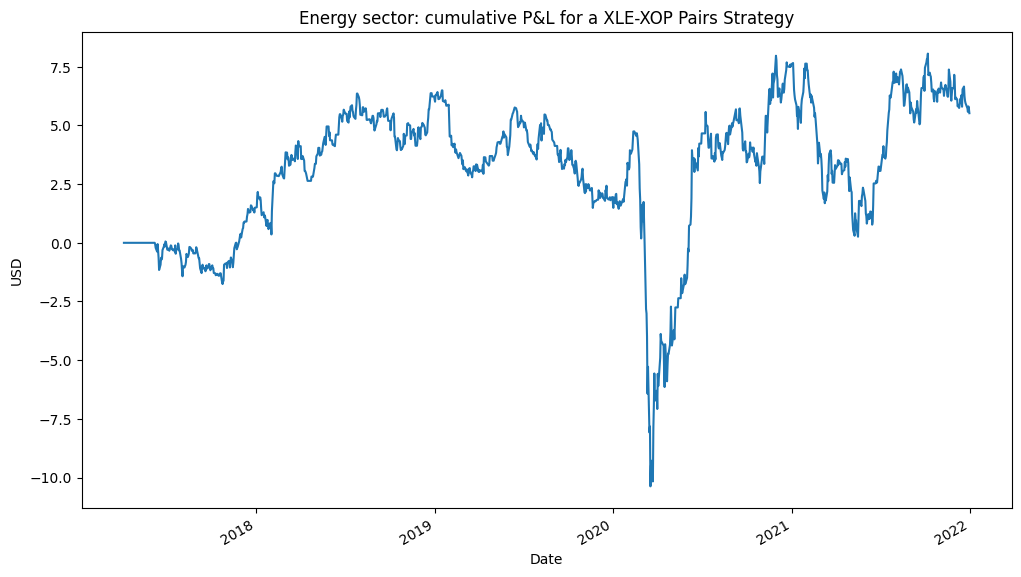

Annualised Sharpe for Energy sector pair strategy ≈ 0.19


In [8]:
# Strategy returns
spread_returns = spread_energy.iloc[roll_window:].diff()
strategy_ret = position_energy_no_switch.shift() * spread_returns
cum_pnl_energy_no_switch = strategy_ret.cumsum()
cum_pnl_energy_no_switch.name = "PnL Energy pair"

# Results
fig, ax = plt.subplots()
cum_pnl_energy_no_switch.plot(ax=ax, title="Energy sector: cumulative P&L for a XLE-XOP Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_energy_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Energy sector pair strategy ≈ {annual_sharpe_energy_no_switch:.2f}")

With the new exit trade condition, the annualised Sharpe ratio grows to $0.19$ from $0.09$ in section 1.b.

In the following, we derive the pair strategy with added regime switching indicator.

In [9]:
# apply vol switch to trading strategy 
position_energy_with_switch = position_energy_no_switch.where(~switch_high_vol, 0)

#position_energy_with_switch = position_energy_with_switch.fillna(0)		# fills string of initial na (before first trade) to 0
position_energy_with_switch.name = "Spread Position"
# position_energy_with_switch

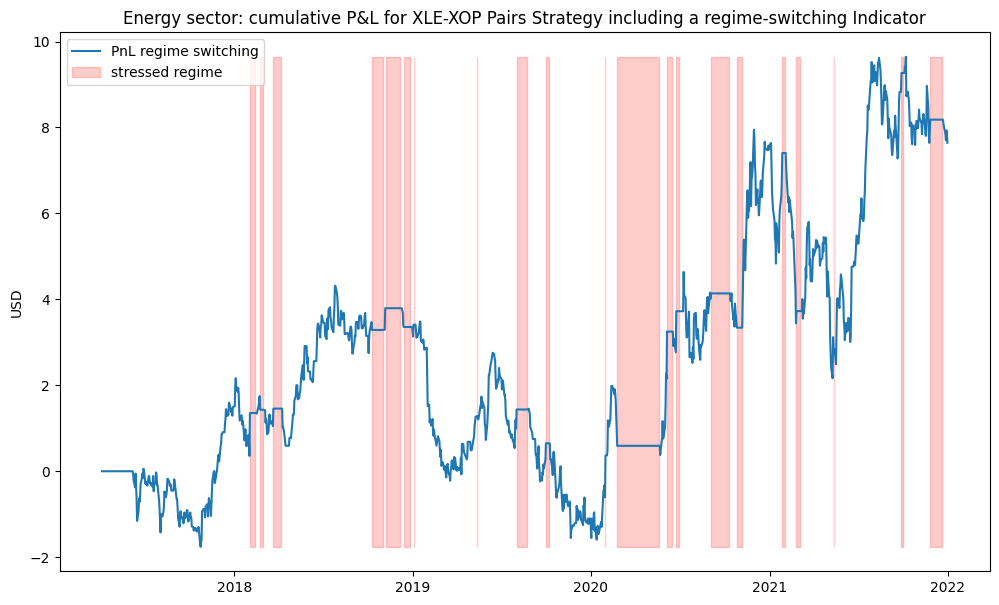

Annualised Sharpe for Energy sector pair strategy ≈ 0.39


In [10]:
# Strategy returns
spread_returns = spread_energy.iloc[roll_window:].diff()
strategy_ret = position_energy_with_switch.shift() * spread_returns
cum_pnl_energy_with_switch = strategy_ret.cumsum()
cum_pnl_energy_with_switch.name = "PnL Energy pair"

min_pnl = cum_pnl_energy_with_switch.min()
max_pnl = cum_pnl_energy_with_switch.max()
# Results
plt.plot(cum_pnl_energy_with_switch.index, cum_pnl_energy_with_switch, label="PnL regime switching")
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime")
plt.ylabel("USD")
plt.title("Energy sector: cumulative P&L for XLE-XOP Pairs Strategy including a regime-switching Indicator")
plt.legend()
plt.show()

annual_sharpe_energy_with_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Energy sector pair strategy ≈ {annual_sharpe_energy_with_switch:.2f}")

We observe the regime switching indicator to be a beneficial add-on to the pair strategy, increasing the annualise Sharpe ratio from $0.19$ to $0.39$.

We aggregate the vanilla and the regime switching strategy in the graph below for comparison.

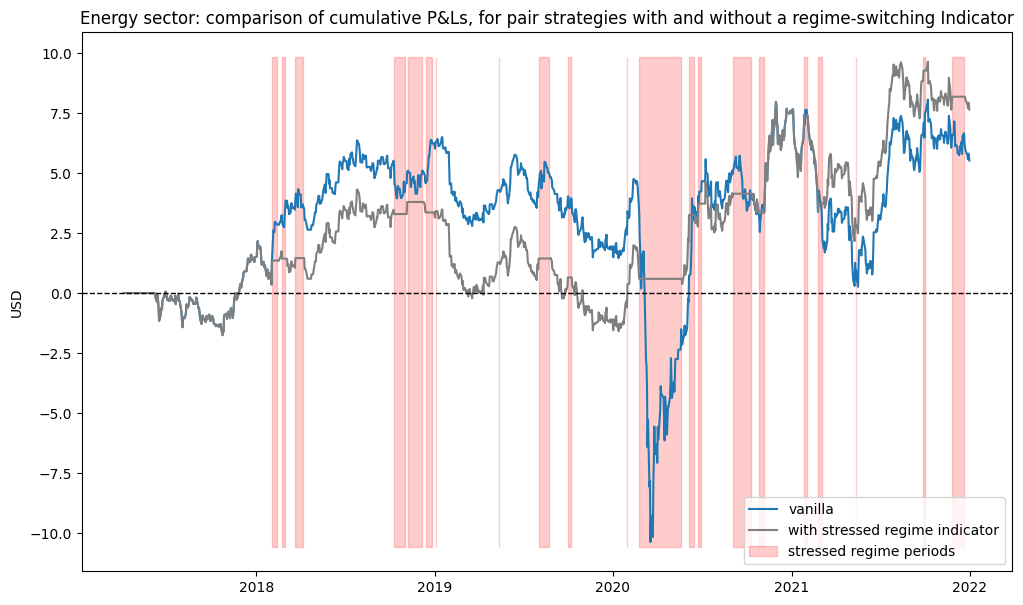

In [11]:
# comparison of switch vs no-switch strategies
min_pnl = min(cum_pnl_energy_with_switch.min(), cum_pnl_energy_no_switch.min())
max_pnl = max(cum_pnl_energy_with_switch.max(), cum_pnl_energy_no_switch.max())

#plt.plot(cum_pnl_energy.index, cum_pnl_energy)
plt.plot(cum_pnl_energy_no_switch.index, cum_pnl_energy_no_switch, color='tab:blue', label="vanilla")
plt.plot(cum_pnl_energy_with_switch.index, cum_pnl_energy_with_switch, color='tab:gray', label="with stressed regime indicator")
plt.fill_between(switch_high_vol.index, min_pnl-0.2, max_pnl+0.2, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime periods")
plt.axhline(0, ls="--", color="k", lw=1)
plt.ylabel("USD")
plt.title("Energy sector: comparison of cumulative P&Ls, for pair strategies with and without a regime-switching Indicator")
plt.legend(loc="lower right")

plt.show()

It is remarkable that the improved pair strategy with indicator is able to completely avoid the big drawdown experienced by the vanilla strategy in the first quarter of 2020.

#### Strategy 2: Gold ETFs

We apply the strategy to the Gold sector ETFs.

In [12]:
# OLS regression and spread
y = prices["GDX"]
X = sm.add_constant(prices["GLD"])
model_gold = sm.OLS(y, X).fit()
alpha_gold, beta_gold = model_gold.params
spread_gold = y - (alpha_gold + beta_gold * prices["GLD"])
spread_gold.name = "Spread"

In [13]:
# baseline strategy
roll_window = 63 # trimestral
zscore_gold = (spread_gold - spread_gold.rolling(roll_window).mean()) / spread_gold.rolling(roll_window).std()
long_entry  = zscore_gold <= -2
short_entry = zscore_gold >=  2
# new: exit position when zscore changes sign (or its abs value is less than tolerance=0.1)
exit_no_switch = np.sign(zscore_gold) != np.sign(zscore_gold.shift())
exit_no_switch = exit_no_switch.where(exit_no_switch, zscore_gold.abs() < 0.1)

position_gold_no_switch = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_gold_no_switch = pd.Series(position_gold_no_switch, index=prices.index).ffill().where(~exit_no_switch, 0).iloc[roll_window:]
position_gold_no_switch = position_gold_no_switch.fillna(0)		# fills string of initial na (before first trade) to 0
position_gold_no_switch.name = "Spread Position"
# position_gold

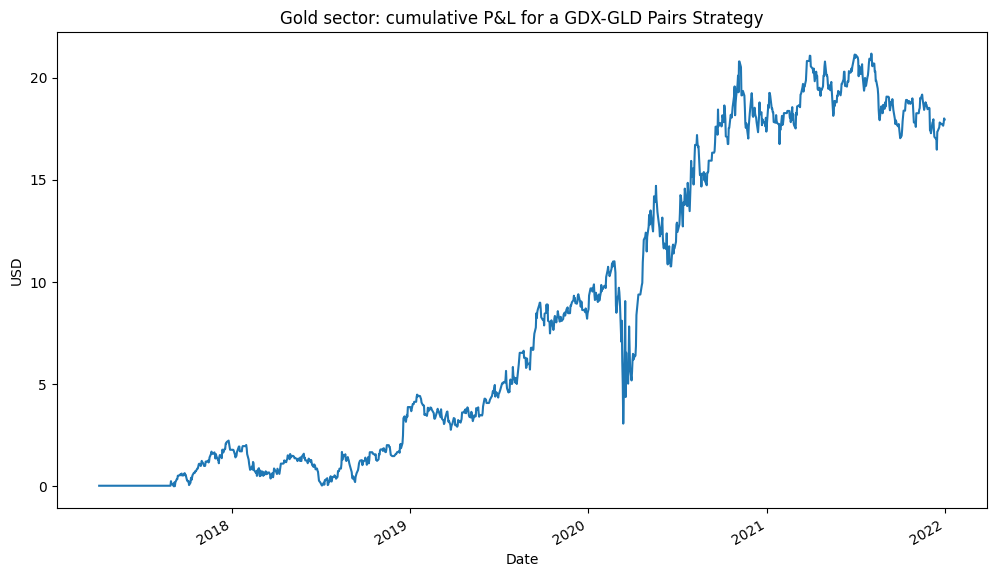

Annualised Sharpe for Gold sector pair strategy ≈ 0.61


In [14]:
# Strategy returns
spread_returns = spread_gold.iloc[roll_window:].diff()
strategy_ret = position_gold_no_switch.shift() * spread_returns
cum_pnl_gold_no_switch = strategy_ret.cumsum()
cum_pnl_gold_no_switch.name = "PnL Gold pair"

# Results
fig, ax = plt.subplots()
cum_pnl_gold_no_switch.plot(ax=ax, title="Gold sector: cumulative P&L for a GDX-GLD Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_gold_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Gold sector pair strategy ≈ {annual_sharpe_gold_no_switch:.2f}")

The annualised Sharpe ratio of the vanilla strategy with updated exit condition is slightly less than that with the previous exit condition ($0.61$ vs $0.69$).

We remind that this was the most effortlessly cointegrated pair among the three considered.

In [15]:
# apply vol switch to trading strategy 
position_gold_with_switch = position_gold_no_switch.where(~switch_high_vol, 0)

position_gold_with_switch.name = "Spread Position"
# position_gold_with_switch

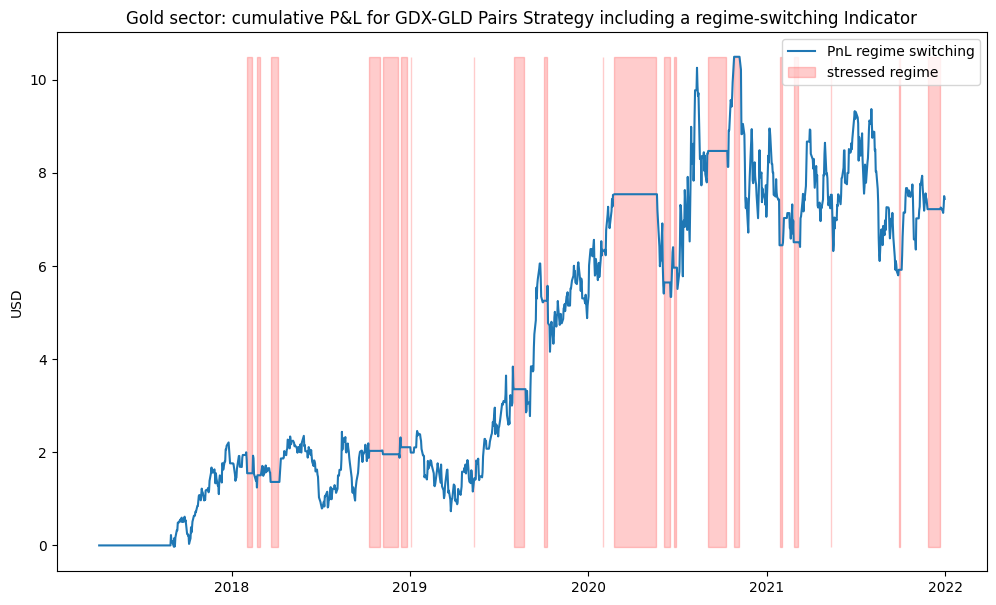

Annualised Sharpe for Gold sector pair strategy ≈ 0.40


In [16]:
# Strategy returns
spread_returns = spread_gold.iloc[roll_window:].diff()
strategy_ret = position_gold_with_switch.shift() * spread_returns
cum_pnl_gold_with_switch = strategy_ret.cumsum()
cum_pnl_gold_with_switch.name = "PnL Gold pair"

min_pnl = cum_pnl_gold_with_switch.min()
max_pnl = cum_pnl_gold_with_switch.max()
# Results
plt.plot(cum_pnl_gold_with_switch.index, cum_pnl_gold_with_switch, label="PnL regime switching")
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime")
plt.ylabel("USD")
plt.title("Gold sector: cumulative P&L for GDX-GLD Pairs Strategy including a regime-switching Indicator")
plt.legend()
plt.show()

annual_sharpe_gold_with_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Gold sector pair strategy ≈ {annual_sharpe_gold_with_switch:.2f}")

The annualised Sharpe ratio of the regime switching strategy is more than $30 \%$ down with respect to the vanilla strategy.

This is readily explained by the fact that Gold is a refuge asset in times of crisis, and as a result the cointegrated ETFs did not in fact lose much money during the Covid 2020 crisis.
The improved pair strategy, by virtue of stopping to trade during high volatility times, unwittingly foregoes the profits made by this refuge asset in the immediate afterward of such junctures.

This is visible if we superimpose profits from the vanilla and from the regime switching pair strategies:

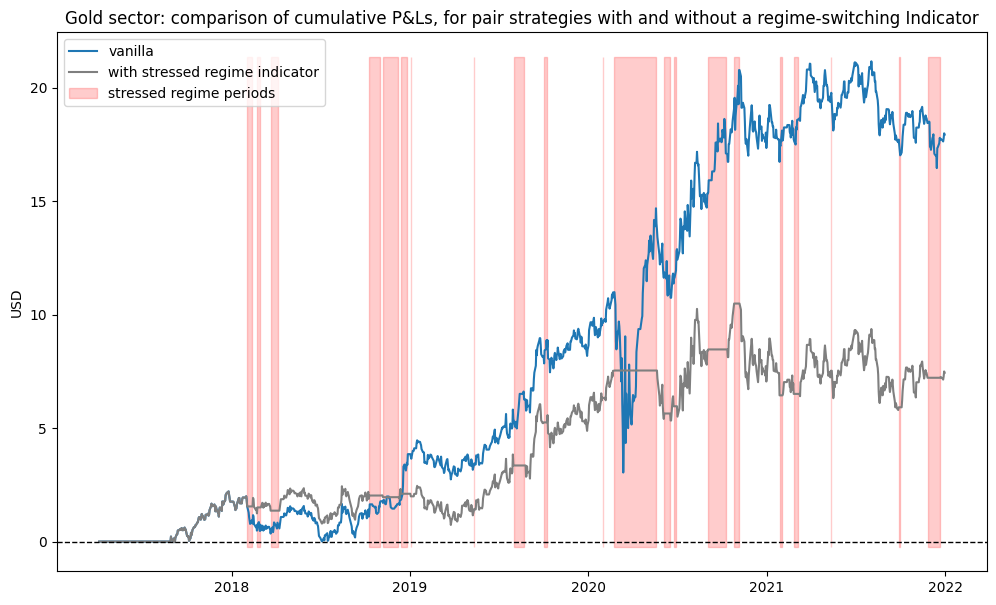

In [17]:
# comparison of switch vs no-switch strategies
min_pnl = min(cum_pnl_gold_with_switch.min(), cum_pnl_gold_no_switch.min())
max_pnl = max(cum_pnl_gold_with_switch.max(), cum_pnl_gold_no_switch.max())

plt.plot(cum_pnl_gold_no_switch.index, cum_pnl_gold_no_switch, color='tab:blue', label="vanilla")
plt.plot(cum_pnl_gold_with_switch.index, cum_pnl_gold_with_switch, color='tab:gray', label="with stressed regime indicator")
plt.fill_between(switch_high_vol.index, min_pnl-0.2, max_pnl+0.2, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime periods")
plt.axhline(0, ls="--", color="k", lw=1)
plt.ylabel("USD")
plt.title("Gold sector: comparison of cumulative P&Ls, for pair strategies with and without a regime-switching Indicator")
plt.legend(loc="upper left")

plt.show()

#### Strategy 3: Technology ETFs

Lastly, the technology ETFs.

In [18]:
# OLS regression and spread
y = prices["IYW"]
X = sm.add_constant(prices["XLK"])
model_tech = sm.OLS(y, X).fit()
alpha_tech, beta_tech = model_tech.params
spread_tech = y - (alpha_tech + beta_tech * prices["XLK"])
spread_tech.name = "Spread"

In [19]:
# baseline strategy
roll_window = 63 # trimestral
zscore_tech = (spread_tech - spread_tech.rolling(roll_window).mean()) / spread_tech.rolling(roll_window).std()
long_entry  = zscore_tech <= -2
short_entry = zscore_tech >=  2
# new: exit position when zscore changes sign (or its abs value is less than tolerance=0.1)
exit_no_switch = np.sign(zscore_tech) != np.sign(zscore_tech.shift())
exit_no_switch = exit_no_switch.where(exit_no_switch, zscore_tech.abs() < 0.1)

position_tech_no_switch = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_tech_no_switch = pd.Series(position_tech_no_switch, index=prices.index).ffill().where(~exit_no_switch, 0).iloc[roll_window:]
position_tech_no_switch = position_tech_no_switch.fillna(0)		# fills string of initial na (before first trade) to 0
position_tech_no_switch.name = "Spread Position"
# position_tech

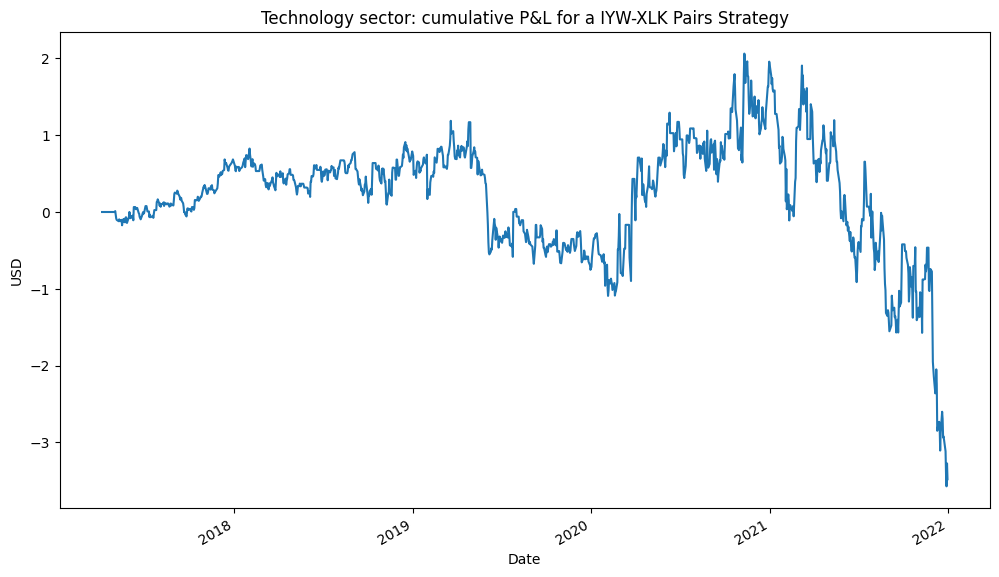

Annualised Sharpe for Technology sector pair strategy ≈ -0.31


In [20]:
# Strategy returns
spread_returns = spread_tech.iloc[roll_window:].diff()
strategy_ret = position_tech_no_switch.shift() * spread_returns
cum_pnl_tech_no_switch = strategy_ret.cumsum()
cum_pnl_tech_no_switch.name = "PnL Technology pair"

# Results
fig, ax = plt.subplots()
cum_pnl_tech_no_switch.plot(ax=ax, title="Technology sector: cumulative P&L for a IYW-XLK Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_tech_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Technology sector pair strategy ≈ {annual_sharpe_tech_no_switch:.2f}")

Annualised Sharpe ratio of vanilla pair strategy with new exit condition for these ETFs is magnified $10 \times$ for the worst, from $-0.03$ to $-0.31$.

In [21]:
# apply vol switch to trading strategy 
position_tech_with_switch = position_tech_no_switch.where(~switch_high_vol, 0)

position_tech_with_switch.name = "Spread Position"
# position_tech_with_switch

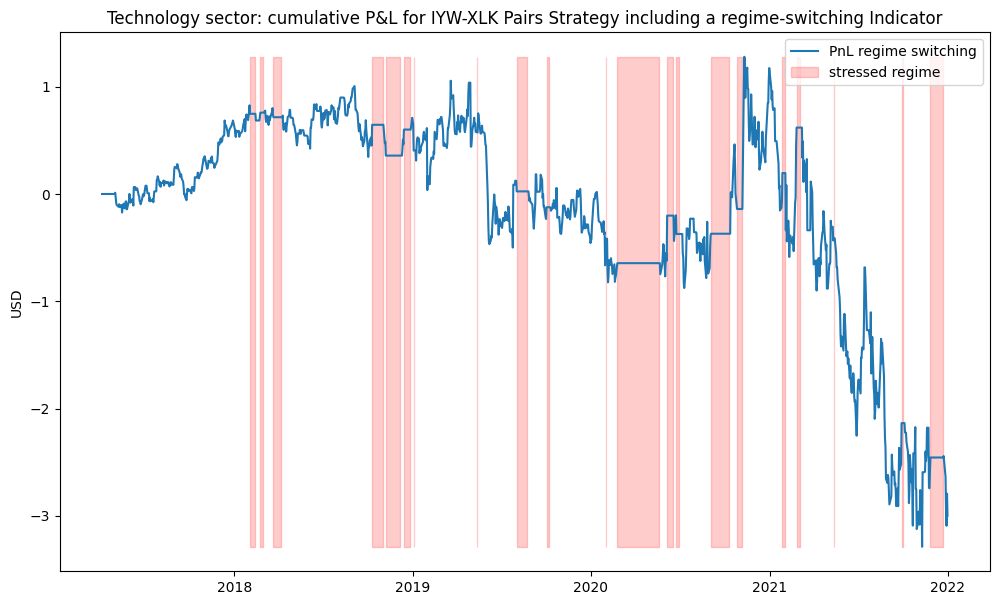

Annualised Sharpe for Technology sector pair strategy ≈ -0.32


In [22]:
# Strategy returns
spread_returns = spread_tech.iloc[roll_window:].diff()
strategy_ret = position_tech_with_switch.shift() * spread_returns
cum_pnl_tech_with_switch = strategy_ret.cumsum()
cum_pnl_tech_with_switch.name = "PnL Technology pair"

min_pnl = cum_pnl_tech_with_switch.min()
max_pnl = cum_pnl_tech_with_switch.max()
# Results
plt.plot(cum_pnl_tech_with_switch.index, cum_pnl_tech_with_switch, label="PnL regime switching")
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime")
plt.ylabel("USD")
plt.title("Technology sector: cumulative P&L for IYW-XLK Pairs Strategy including a regime-switching Indicator")
plt.legend()
plt.show()

annual_sharpe_tech_with_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Technology sector pair strategy ≈ {annual_sharpe_tech_with_switch:.2f}")

Adding the regime-switching indicator to the pair strategy for the technology sector does in fact make little if any difference in terms of annualised Sharpe ratio, and also as seen in the comparison graph below.

This might be explained with the peculiar nature of the Covid 2020 crisis and the lockdowns, which forced people indoors and as a result spurred growth for electronic devices and internet use.
This sector actually profited from the Covid 2020 crisis, and the the pair strategy fails to take advantage of this.

However, with respect to the vanilla strategy, the improved regime-switching strategy manages to avoid losses during high-volatility periods after 2020, and as a result the two strategies finish at the same level of profitability (loss, really) at the end of the timeframe considered (January 2022).

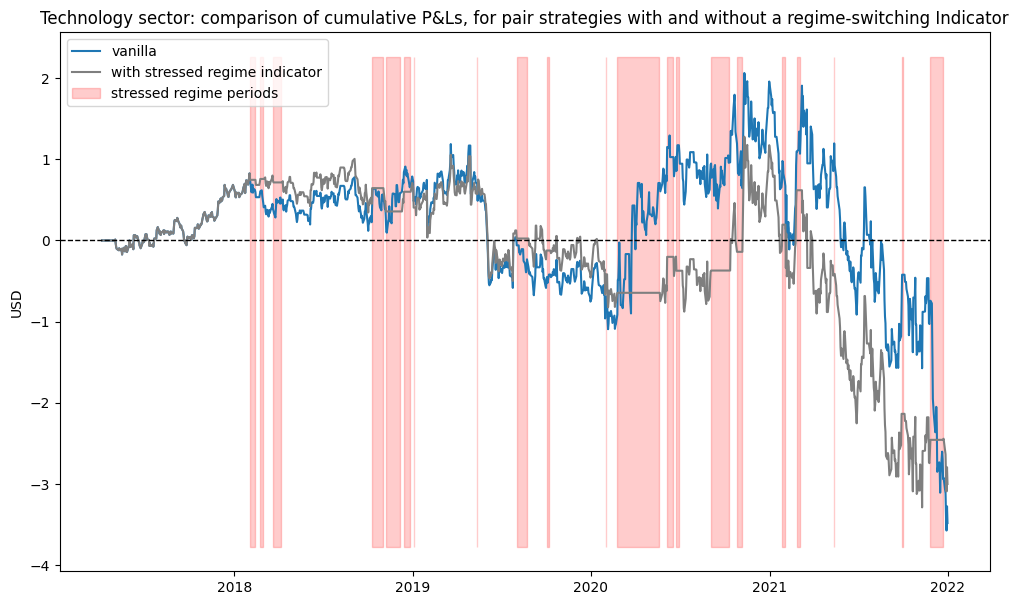

In [23]:
# comparison of switch vs no-switch strategies
min_pnl = min(cum_pnl_tech_with_switch.min(), cum_pnl_tech_no_switch.min())
max_pnl = max(cum_pnl_tech_with_switch.max(), cum_pnl_tech_no_switch.max())

plt.plot(cum_pnl_tech_no_switch.index, cum_pnl_tech_no_switch, color='tab:blue', label="vanilla")
plt.plot(cum_pnl_tech_with_switch.index, cum_pnl_tech_with_switch, color='tab:gray', label="with stressed regime indicator")
plt.fill_between(switch_high_vol.index, min_pnl-0.2, max_pnl+0.2, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime periods")
plt.axhline(0, ls="--", color="k", lw=1)
plt.ylabel("USD")
plt.title("Technology sector: comparison of cumulative P&Ls, for pair strategies with and without a regime-switching Indicator")
plt.legend(loc="upper left")

plt.show()

## Step 3

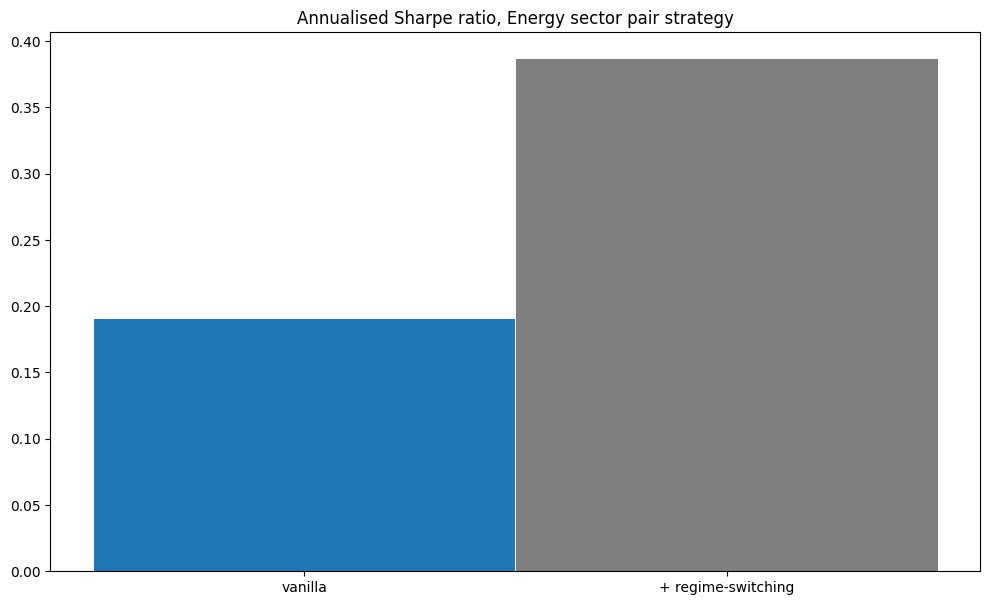

In [24]:
# compare annualised Sharpe ratios
x = ["vanilla", "+ regime-switching"] # np.arange(2)
y = [annual_sharpe_energy_no_switch, annual_sharpe_energy_with_switch]

fig, ax = plt.subplots()

ax.bar(x, y, width=1, color=["tab:blue", "tab:gray"], edgecolor="white", linewidth=0.7)
ax.set_title("Annualised Sharpe ratio, Energy sector pair strategy")

# ax.set(xlim=(0, 8), xticks=np.arange(1, ),
#       ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()